# Bank Balance Forecasting with XGBoost
## Loading from Excel (Data.xlsx)

### Step 1: Install Required Packages

In [29]:
# Run this once to install packages
!pip install pandas numpy xgboost scikit-learn matplotlib seaborn openpyxl --break-system-packages

### Step 2: Import Libraries

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import (
    TimeSeriesSplit,
    train_test_split,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)
from sklearn.base import clone
from xgboost.callback import EarlyStopping

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


### Step 3: Load Data from Excel

In [31]:
# Load Excel file
# Adjust sheet_name if your data is in a different sheet
df = pd.read_excel('Data.xlsx', sheet_name=1)  # 1 = second sheet

print(f"✓ Loaded {len(df)} rows from Data.xlsx")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

✓ Loaded 5623 rows from Data.xlsx

Columns: ['Date', 'Description', 'Name', 'Category', 'Credit', 'Debit', 'Balance', 'Currency']

First few rows:


,Date,Description,Name,Category,Credit,Debit,Balance,Currency
0,2025-10-27,Real Time Payment From Amazon.com 10/25 202510...,Amazon,Marketplace Payments,4685.33,NaN,34587.86,USD
1,2025-10-27,Electronic Deposit 10/27 Afterpay 1217,AfterPay,"ENTERTAINMENT_TV_AND_MOVIES, ENTERTAINMENT, GE...",2258.80,NaN,29902.53,USD
2,2025-10-27,Electronic Deposit 10/27 Shopify,NaN,Marketplace Payments,4204.92,NaN,27643.73,USD
3,2025-10-27,Real Time Payment From Amazon.com 10/26 202510...,Amazon,Marketplace Payments,5755.01,NaN,23438.81,USD
4,2025-10-27,Internet Banking Payment To Credit Line 10/25 ...,NaN,LOAN_PAYMENTS_CREDIT_CARD_PAYMENT,NaN,-3264.65,17683.80,USD


### Step 4: Data Preprocessing

In [32]:
def load_and_preprocess_data(filepath_or_data):
    """
    Load bank transaction data from CSV, Excel, or DataFrame
    """
    if isinstance(filepath_or_data, str):
        # Check file extension
        if filepath_or_data.endswith('.xlsx') or filepath_or_data.endswith('.xls'):
            df = pd.read_excel(filepath_or_data)
        else:
            df = pd.read_csv(filepath_or_data)
    else:
        df = filepath_or_data.copy()
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.strip()
    
    # Convert date
    df['date'] = pd.to_datetime(df['date'])
    
    # Fill NaN credits/debits with 0
    df['credit'] = df['credit'].fillna(0)
    df['debit'] = df['debit'].fillna(0)
    
    # Aggregate to daily level (take end-of-day balance)
    daily_df = df.groupby('date').agg({
        'balance': 'last',
        'credit': 'sum',
        'debit': 'sum'
    }).reset_index()
    
    return daily_df

# Preprocess the data
Data = load_and_preprocess_data(df)
Data = Data.set_index('date')
Data = Data[Data.index >= "2000-01-01"]

print(f"✓ Preprocessed to {len(Data)} daily records")
print(f"  Balance range: ${Data['balance'].min():,.2f} to ${Data['balance'].max():,.2f}")
print(f"\nDaily data preview:")
Data.head()

✓ Preprocessed to 250 daily records
  Balance range: $-6,994.28 to $893,298.39

Daily data preview:


,balance,credit,debit
date,,,
2024-10-28,545510.36,33287.09,-135198.48
2024-10-29,440801.69,213247.45,-54371.47
2024-10-30,624029.58,34350.43,-66782.79
2024-10-31,568647.74,35280.15,-103999.55
2024-11-01,488661.75,108548.34,-66784.32


<Axes: xlabel='date'>

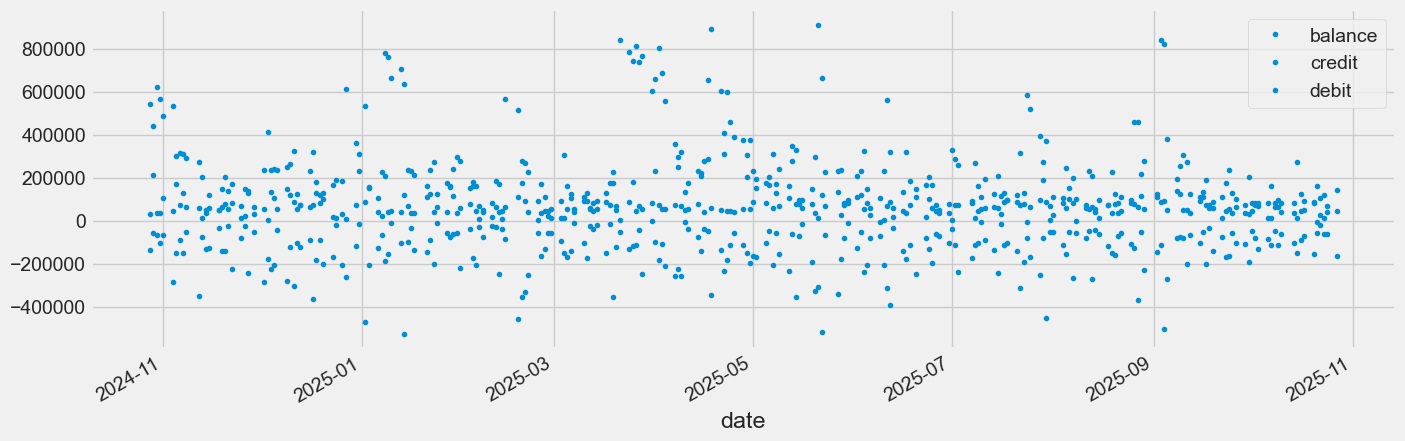

In [33]:
Data.plot(style=".", figsize = (15,5), color = color_pal[0])
#For the purpose of this forecast, we will only focus on the balance value

### Step 5: Quick Data Exploration

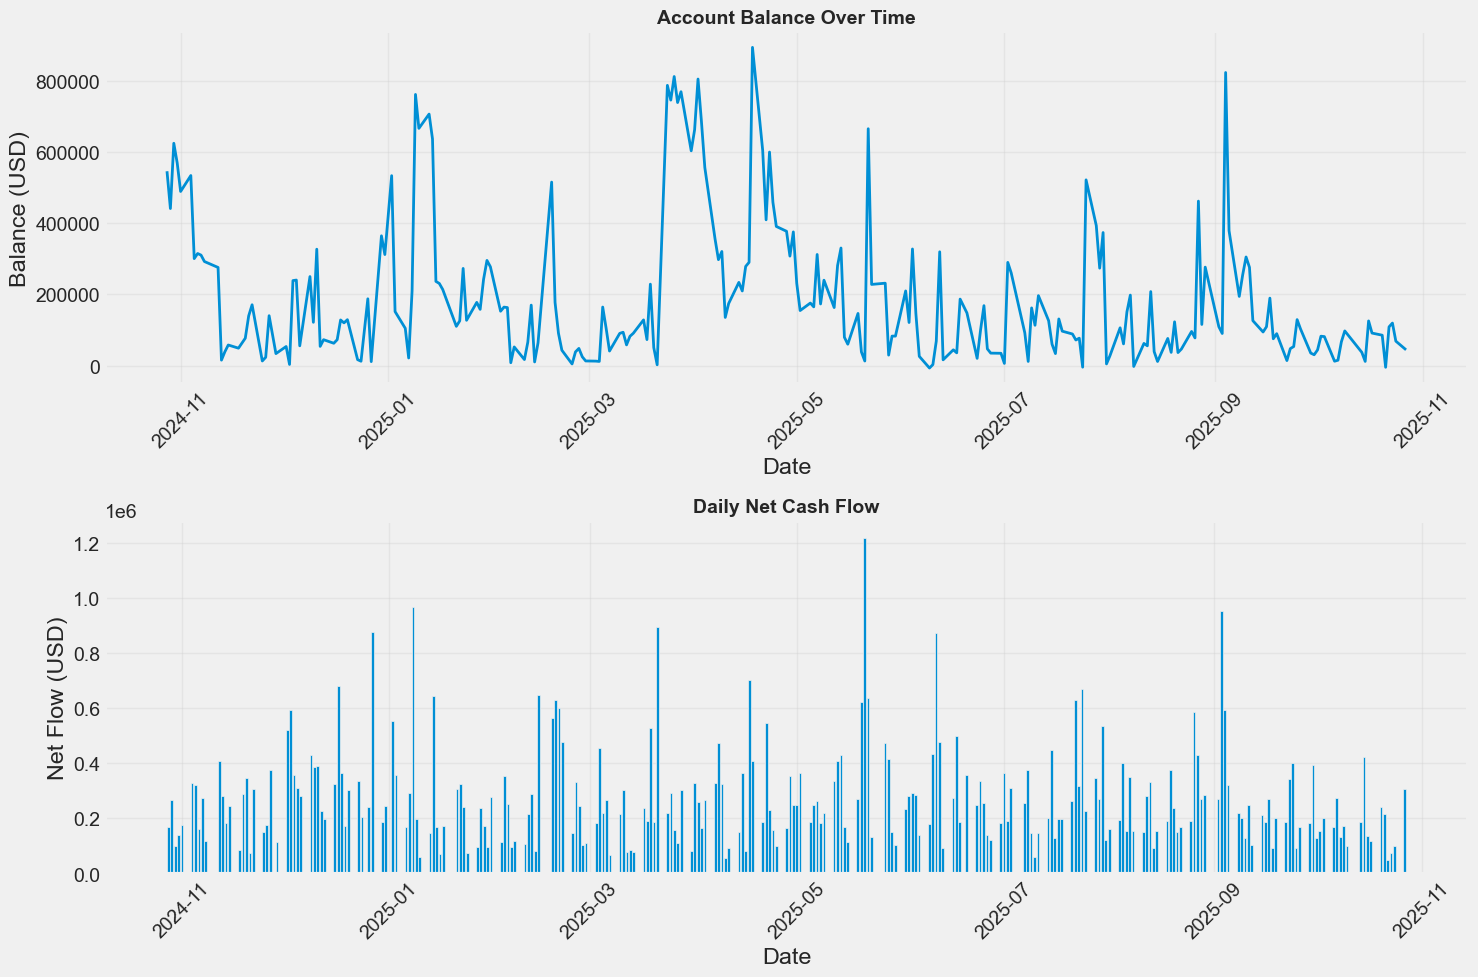


📊 Summary Statistics:
  Average Balance: $191,075.55
  Std Dev Balance: $197,550.64
  Average Daily Credits: $136,620.48
  Average Daily Debits: $-138,653.52
  Average Net Flow: $275,274.00


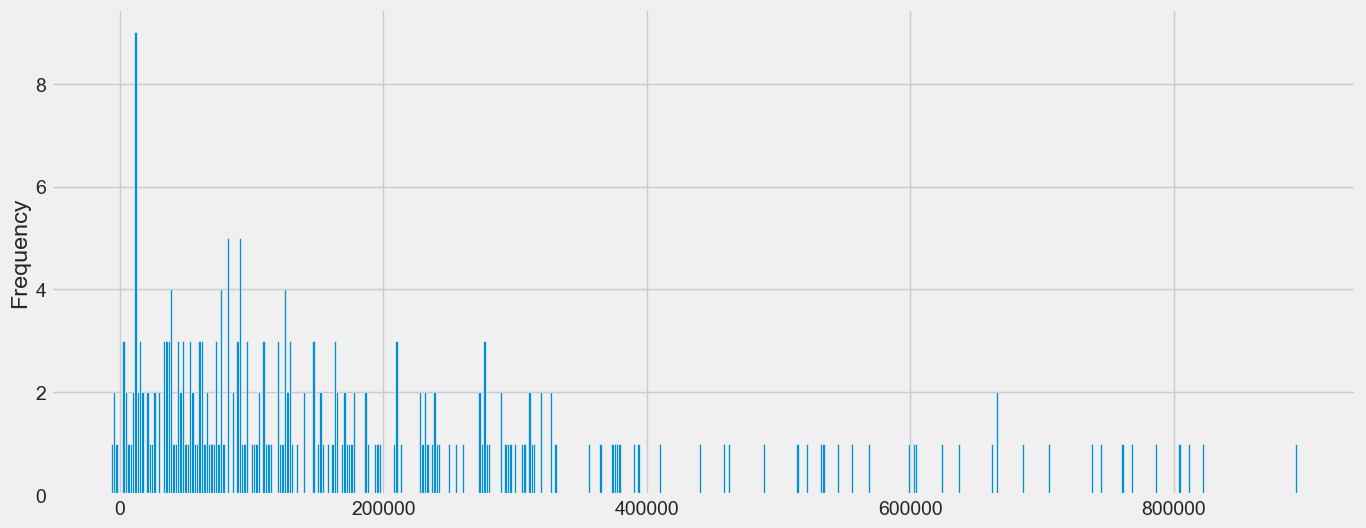

In [34]:
# Plot balance over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Balance trend
axes[0].plot(Data['balance'], linewidth=2)
axes[0].set_title('Account Balance Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Balance (USD)')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Daily net flow (credits - debits)
Data['net_flow'] = Data['credit'] - Data['debit']
axes[1].bar(Data.index, Data['net_flow'], width=0.8)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_title('Daily Net Cash Flow', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Net Flow (USD)')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Summary Statistics:")
print(f"  Average Balance: ${Data['balance'].mean():,.2f}")
print(f"  Std Dev Balance: ${Data['balance'].std():,.2f}")
print(f"  Average Daily Credits: ${Data['credit'].mean():,.2f}")
print(f"  Average Daily Debits: ${Data['debit'].mean():,.2f}")
print(f"  Average Net Flow: ${Data['net_flow'].mean():,.2f}")       

Data['balance'].plot(kind = "hist", bins = 500)
plt.show()

### Step 6: Define XGBoost Forecaster Class

In [35]:
class BankTransactionForecaster:
    """
    XGBoost-based forecaster for bank transaction time series
    """
    
    def __init__(self, horizon=7, lag_features=14):
        self.horizon = horizon
        self.lag_features = lag_features
        self.model = None
        self.feature_names = []
        
    def create_time_features(self, df):
        """Create time-based features"""
        df = df.copy()
        df['day_of_week'] = df.index.dayofweek
        df['day_of_month'] = df.index.day
        df['week_of_year'] = df.index.isocalendar().week
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df['is_month_start'] = df.index.is_month_start.astype(int)
        df['is_month_end'] = df.index.is_month_end.astype(int)
        df['date_offset'] = (df.index.month*100 + df.index.day - 320)%1300
        df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                              labels = [0, 1, 2, 3])
        #0 = Spirng, 1 = Summer, 2= Fall, 3= Winter
        return df
    
    def create_lag_features(self, df, target_col='balance', n_lags=None):
        """Create lag features"""
        if n_lags is None:
            n_lags = self.lag_features
        df = df.copy()
        for lag in range(1, n_lags + 1):
            df[f'lag_{lag}'] = df[target_col].shift(lag)
        return df
    
    def create_rolling_features(self, df, target_col='balance', windows=[3, 7, 14, 30]):
        """Create rolling window statistics"""
        df = df.copy()
        for window in windows:
            df[f'rolling_mean_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
            df[f'rolling_std_{window}'] = df[target_col].shift(1).rolling(window=window).std()
            df[f'rolling_min_{window}'] = df[target_col].shift(1).rolling(window=window).min()
            df[f'rolling_max_{window}'] = df[target_col].shift(1).rolling(window=window).max()
        return df
    
    def create_transaction_features(self, df):
        """Create features from transaction patterns"""
        df = df.copy()
        df['daily_credits'] = df['credit']
        df['daily_debits'] = df['debit']
        df['daily_net_flow'] = df['daily_credits'] - df['daily_debits']

        
        for lag in [1, 3, 7]:
            df[f'net_flow_lag_{lag}'] = df['daily_net_flow'].shift(lag)
            df[f'credits_lag_{lag}'] = df['daily_credits'].shift(lag)
            df[f'debits_lag_{lag}'] = df['daily_debits'].shift(lag)
        return df
    
    def prepare_data(self, df, target_col='balance'):
        """Main data preparation pipeline"""
        df = df.copy()
        df = self.create_time_features(df)
        df = self.create_transaction_features(df)
        df = self.create_lag_features(df, target_col)
        df = self.create_rolling_features(df, target_col)
        df_clean = df.dropna()
        return df_clean
    
    def train_test_split(self, df, test_size=0.2):
        """Time series split"""
        split_idx = int(len(df) * (1 - test_size))
        train = df.iloc[:split_idx].copy()
        test = df.iloc[split_idx:].copy()
        return train, test
    
    def fit(self, train_df, test_df, target_col='balance', xgb_params=None):
        """Train XGBoost model"""
        if xgb_params is None:
            xgb_params = {
                'objective': 'reg:squarederror',
                'max_depth': 6,
                'learning_rate': 0.1,
                'n_estimators': 100,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42
            }
        
        feature_cols = [col for col in train_df.columns 
                       if col not in [target_col, 'description', 'name', 'category']]
        self.feature_names = feature_cols
        
        X_train = train_df[feature_cols]
        y_train = train_df[target_col]
        
        X_test = test_df[feature_cols]
        y_test = test_df[target_col]
        
        self.model = xgb.XGBRegressor(enable_categorical=True,**xgb_params)
        self.model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)
        return self
    
    def predict(self, test_df):
        """Make predictions"""
        X_test = test_df[self.feature_names]
        return self.model.predict(X_test)
    
    def evaluate(self, test_df, target_col='balance'):
        """Evaluate model"""
        y_true = test_df[target_col].values
        y_pred = self.predict(test_df)
        
        metrics = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100
        }
        return metrics, y_pred
    def cross_validate(
        self,
        df,
        target_col='balance',
        n_splits=5,
        xgb_params=None,
        test_horizon=30,
        gap=30,                 
        inner_val_frac=0.2,     # fraction of fold-train used for early stopping
        plot=True
    ):
        """
        Walk-forward / expanding-window time series cross-validation.

        - test_horizon: number of rows in each fold test set
        - gap: number of rows to leave between train and test (prevents leakage with rolling features)
        - inner_val_frac: portion of fold's training part reserved for early stopping
        """

        if xgb_params is None:
            xgb_params = {
                'objective': 'reg:squarederror',
                'max_depth': 5,
                'learning_rate': 0.05,
                'n_estimators': 1000,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42
            }

        # If user passes already-prepared data, don't prepare again.
        # Heuristic: prepared data should already have lag_1 etc.
        data = df.copy()

        EXCLUDE = {target_col, 'description', 'name', 'category'}
        feature_cols = [c for c in data.columns if c not in EXCLUDE]
        X = data[feature_cols]
        y = data[target_col]

        # TimeSeriesSplit: fixed test set length + optional gap
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_horizon, gap=gap)

        fold_results = []
        oof_pred = np.full(len(data), np.nan, dtype=float)

        if plot:
            fig, axs = plt.subplots(n_splits, 1, figsize=(15, 3*n_splits), sharex=True)

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
            # ----- Inner split for early stopping (NO leakage) -----
            n_train = len(train_idx)
            cut = int((1 - inner_val_frac) * n_train)
            inner_train_idx = train_idx[:cut]
            inner_val_idx   = train_idx[cut:]

            X_tr, y_tr = X.iloc[inner_train_idx], y.iloc[inner_train_idx]
            X_val, y_val = X.iloc[inner_val_idx], y.iloc[inner_val_idx]
            X_te, y_te = X.iloc[test_idx], y.iloc[test_idx]

            model = xgb.XGBRegressor(enable_categorical=True,**xgb_params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

            y_hat = model.predict(X_te)
            oof_pred[test_idx] = y_hat

            fold_metrics = {
                "fold": fold,
                "n_train": len(inner_train_idx),
                "n_val": len(inner_val_idx),
                "n_test": len(test_idx),
                "MAE": mean_absolute_error(y_te, y_hat),
                "RMSE": float(np.sqrt(mean_squared_error(y_te, y_hat))),
                "best_iteration": getattr(model, "best_iteration", None)
            }
            fold_results.append(fold_metrics)

            if plot:
                ax = axs[fold-1] if n_splits > 1 else axs
                data[target_col].iloc[test_idx].plot(ax=ax, label="Actual (fold test)")
                pd.Series(y_hat, index=data.index[test_idx]).plot(ax=ax, label="Pred (fold test)")
                ax.axvline(data.index[test_idx].min(), color='black', ls='--')
                ax.legend(loc="upper left")

        summary = {
            "RMSE_mean": float(np.mean([r["RMSE"] for r in fold_results])),
            "RMSE_std": float(np.std([r["RMSE"] for r in fold_results])),
            "MAE_mean": float(np.mean([r["MAE"] for r in fold_results])),
            "MAE_std": float(np.std([r["MAE"] for r in fold_results])),
        }

        print("CV summary:", summary)
        print("Fold metrics:")
        for r in fold_results:
            print(r)

        if plot:
            plt.show()

        return fold_results, summary, pd.Series(oof_pred, index=data.index, name="oof_pred")
        
        


print("✓ BankTransactionForecaster class defined")

✓ BankTransactionForecaster class defined


### Step 7: Prepare Features


In [36]:
# Initialize forecaster
forecaster = BankTransactionForecaster(lag_features=14)


# Create features
Data_prepared = forecaster.prepare_data(Data, target_col='balance')

print(f"✓ Features created!")
print(f"  Total features: {len(Data_prepared.columns)}")
print(f"  Usable rows: {len(Data_prepared)} (after removing NaN from lags)")
print(f"\nFeature columns:")
print([col for col in Data_prepared.columns if col not in ['balance', 'credit', 'debit']])
Data_prepared.head()


✓ Features created!
  Total features: 56
  Usable rows: 219 (after removing NaN from lags)

Feature columns:
['net_flow', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'date_offset', 'season', 'daily_credits', 'daily_debits', 'daily_net_flow', 'net_flow_lag_1', 'credits_lag_1', 'debits_lag_1', 'net_flow_lag_3', 'credits_lag_3', 'debits_lag_3', 'net_flow_lag_7', 'credits_lag_7', 'debits_lag_7', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'rolling_mean_3', 'rolling_std_3', 'rolling_min_3', 'rolling_max_3', 'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_min_14', 'rolling_max_14', 'rolling_mean_30', 'rolling_std_30', 'rolling_min_30', 'rolling_max_30']


,balance,credit,debit,net_flow,day_of_week,day_of_month,week_of_year,month,quarter,is_weekend,is_month_start,is_month_end,date_offset,season,daily_credits,daily_debits,daily_net_flow,net_flow_lag_1,credits_lag_1,debits_lag_1,net_flow_lag_3,credits_lag_3,debits_lag_3,net_flow_lag_7,credits_lag_7,debits_lag_7,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,rolling_mean_7,rolling_std_7,rolling_min_7,rolling_max_7,rolling_mean_14,rolling_std_14,rolling_min_14,rolling_max_14,rolling_mean_30,rolling_std_30,rolling_min_30,rolling_max_30
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-11,326645.87,87333.60,-302384.97,389718.57,2,11,50,12,4,0,0,0,891,2,87333.60,-302384.97,389718.57,385505.90,266006.58,-119499.32,281319.84,237211.11,-44108.73,520328.89,237006.26,-283322.63,121396.03,249770.21,55366.98,239953.66,238531.74,3062.68,53411.62,33509.63,139942.02,23234.64,12793.96,170619.76,139463.23,76746.50,142177.740000,98853.748343,55366.98,249770.21,137356.131429,104449.381349,3062.68,249770.21,111271.618571,87726.446560,3062.68,249770.21,215809.023333,191353.674505,3062.68,624029.58
2024-12-12,53830.37,123935.54,-103383.87,227319.41,3,12,50,12,4,0,0,0,892,2,123935.54,-103383.87,227319.41,389718.57,87333.60,-302384.97,428851.10,150534.85,-278316.25,592498.28,414269.74,-178228.54,326645.87,121396.03,249770.21,55366.98,239953.66,238531.74,3062.68,53411.62,33509.63,139942.02,23234.64,12793.96,170619.76,139463.23,232604.036667,103696.105690,121396.03,326645.87,176389.595714,118023.079929,3062.68,326645.87,129121.573571,104063.765361,3062.68,326645.87,208513.540333,182308.543566,3062.68,624029.58
2024-12-13,72593.40,75726.36,-122909.39,198635.75,4,13,50,12,4,0,0,0,893,2,75726.36,-122909.39,198635.75,227319.41,123935.54,-103383.87,385505.90,266006.58,-119499.32,358716.43,136186.99,-222529.44,53830.37,326645.87,121396.03,249770.21,55366.98,239953.66,238531.74,3062.68,53411.62,33509.63,139942.02,23234.64,12793.96,170619.76,167290.756667,142080.324859,53830.37,326645.87,183642.122857,106604.435823,53830.37,326645.87,123004.940714,105909.433410,3062.68,326645.87,195614.496333,178965.734081,3062.68,624029.58
2024-12-16,62583.47,232738.36,-91123.13,323861.49,0,16,51,12,4,0,0,0,896,2,232738.36,-91123.13,323861.49,198635.75,75726.36,-122909.39,389718.57,87333.60,-302384.97,309446.18,105987.35,-203458.83,72593.40,53830.37,326645.87,121396.03,249770.21,55366.98,239953.66,238531.74,3062.68,53411.62,33509.63,139942.02,23234.64,12793.96,151023.213333,152382.745003,53830.37,326645.87,159936.645714,110734.167924,53830.37,326645.87,116003.057857,105759.628927,3062.68,326645.87,177233.290333,160848.175308,3062.68,568647.74
2024-12-17,72572.39,321180.69,-361133.63,682314.32,1,17,51,12,4,0,0,0,897,2,321180.69,-361133.63,682314.32,323861.49,232738.36,-91123.13,227319.41,123935.54,-103383.87,281319.84,237211.11,-44108.73,62583.47,72593.40,53830.37,326645.87,121396.03,249770.21,55366.98,239953.66,238531.74,3062.68,53411.62,33509.63,139942.02,23234.64,63002.413333,9388.528044,53830.37,72593.40,134598.047143,109660.796609,53830.37,326645.87,119559.451429,102818.268293,3062.68,326645.87,160364.481333,144041.964416,3062.68,533435.05


### Step 8: Train/Test Split

Training set: 175 days
  From: 2024-12-11 00:00:00
  To: 2025-08-22 00:00:00

Test set: 44 days
  From: 2025-08-25 00:00:00
  To: 2025-10-27 00:00:00
CV summary: {'RMSE_mean': 127777.62883142475, 'RMSE_std': 47314.48436443681, 'MAE_mean': 99499.71108506939, 'MAE_std': 30089.801425830552}
Fold metrics:
{'fold': 1, 'n_train': 44, 'n_val': 11, 'n_test': 30, 'MAE': 127407.57085416676, 'RMSE': 186968.56811580397, 'best_iteration': None}
{'fold': 2, 'n_train': 68, 'n_val': 17, 'n_test': 30, 'MAE': 57725.685098958274, 'RMSE': 71157.81505318805, 'best_iteration': None}
{'fold': 3, 'n_train': 92, 'n_val': 23, 'n_test': 30, 'MAE': 113365.87730208311, 'RMSE': 125206.50332528222, 'best_iteration': None}


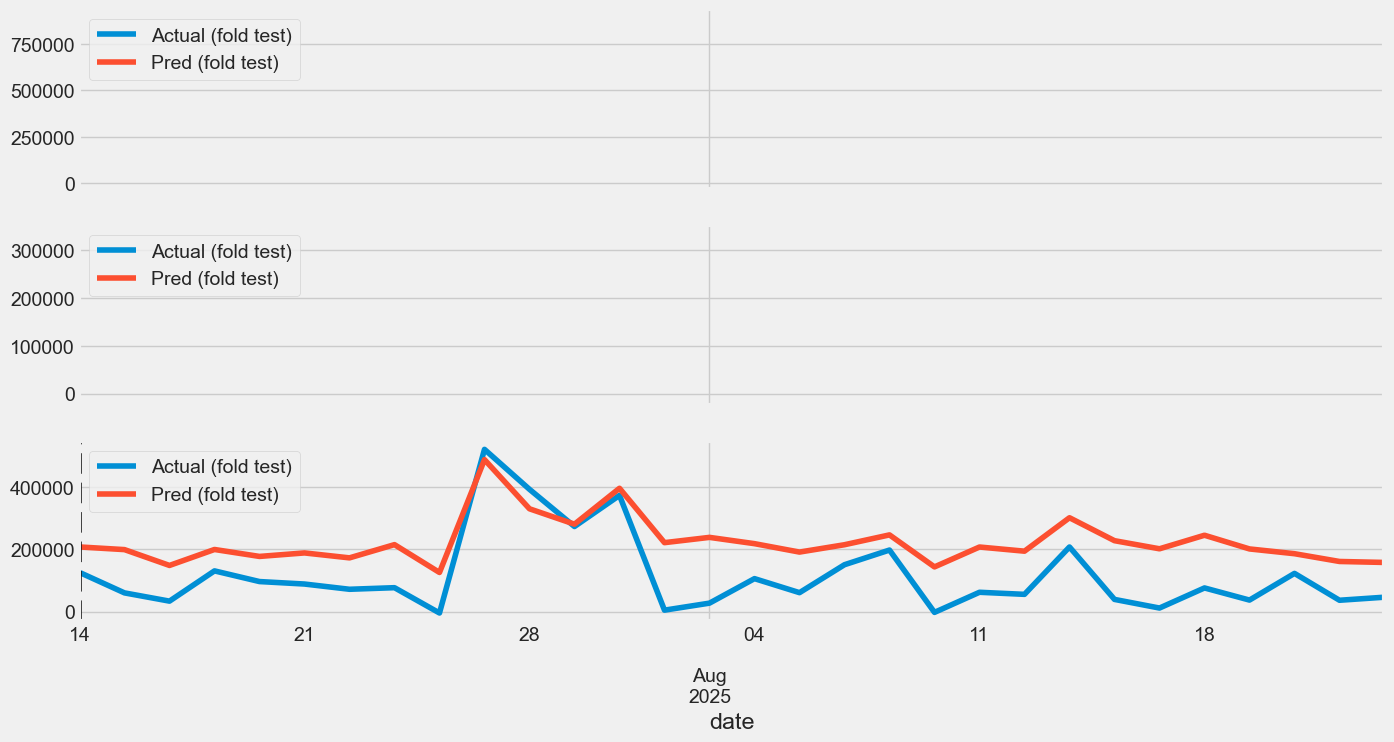

In [37]:
# Split data (80% train, 20% test)
train, test = forecaster.train_test_split(Data_prepared, test_size=0.2)

print(f"Training set: {len(train)} days")
print(f"  From: {train.index.min()}")
print(f"  To: {train.index.max()}")
print(f"\nTest set: {len(test)} days")
print(f"  From: {test.index.min()}")
print(f"  To: {test.index.max()}")

folds, summary, oof = forecaster.cross_validate(
    train,        # or Data (raw daily) — function handles both
    target_col='balance',
    n_splits=3,
    test_horizon=30,
    gap=30,
    plot=True
)


In [38]:
Data_prepared.columns

Index(['balance', 'credit', 'debit', 'net_flow', 'day_of_week', 'day_of_month',
       'week_of_year', 'month', 'quarter', 'is_weekend', 'is_month_start',
       'is_month_end', 'date_offset', 'season', 'daily_credits',
       'daily_debits', 'daily_net_flow', 'net_flow_lag_1', 'credits_lag_1',
       'debits_lag_1', 'net_flow_lag_3', 'credits_lag_3', 'debits_lag_3',
       'net_flow_lag_7', 'credits_lag_7', 'debits_lag_7', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'rolling_mean_3',
       'rolling_std_3', 'rolling_min_3', 'rolling_max_3', 'rolling_mean_7',
       'rolling_std_7', 'rolling_min_7', 'rolling_max_7', 'rolling_mean_14',
       'rolling_std_14', 'rolling_min_14', 'rolling_max_14', 'rolling_mean_30',
       'rolling_std_30', 'rolling_min_30', 'rolling_max_30'],
      dtype='object')

### Step 9: Train XGBoost Model

In [39]:
# Define hyperparameters
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train model
print("Training XGBoost model...")
forecaster.fit(train, test, target_col='balance', xgb_params=xgb_params)
print("✓ Training complete!")

fi = pd.DataFrame(data = forecaster.model.feature_importances_, index = forecaster.model.feature_names_in_,
             columns = ['importance'])

Training XGBoost model...
[0]	validation_0-rmse:199464.71550	validation_1-rmse:155723.67637
[100]	validation_0-rmse:12703.62325	validation_1-rmse:81259.03661
[200]	validation_0-rmse:2014.77217	validation_1-rmse:80843.49130
[300]	validation_0-rmse:413.18849	validation_1-rmse:80884.62757
[400]	validation_0-rmse:94.28780	validation_1-rmse:80903.13706
[499]	validation_0-rmse:22.54473	validation_1-rmse:80900.01087
✓ Training complete!


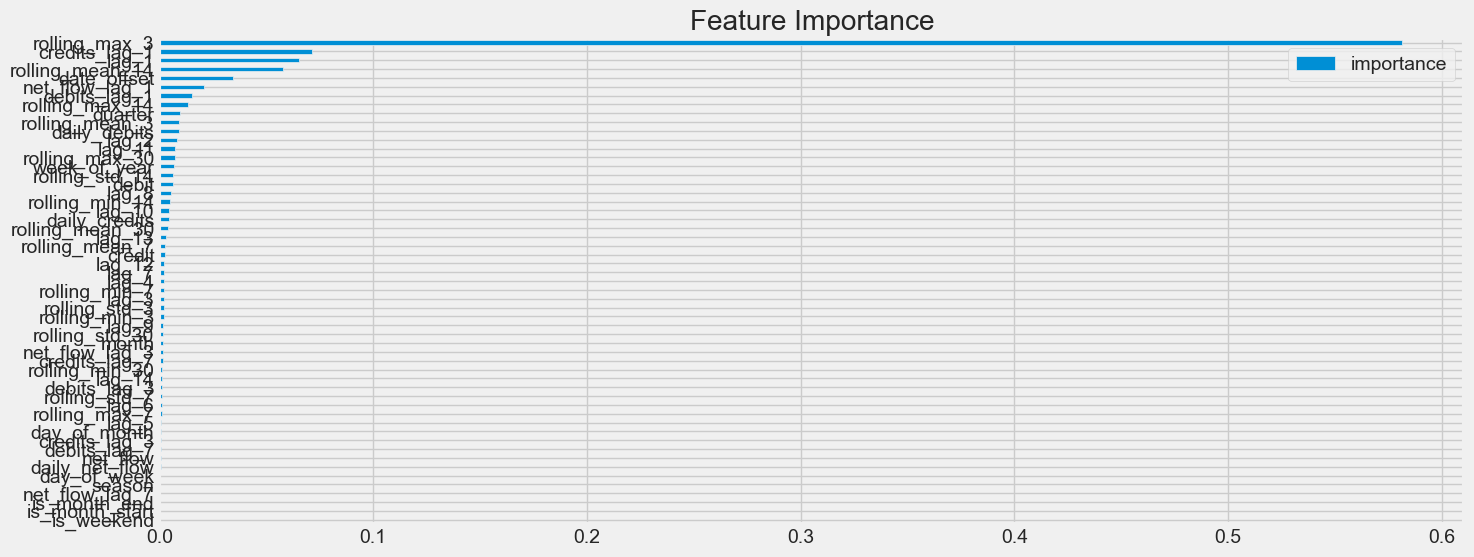

In [40]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

### Step 10: Evaluate Model

In [41]:
# Get predictions and metrics
metrics, predictions = forecaster.evaluate(test, target_col='balance')

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"MAE (Mean Absolute Error):  ${metrics['MAE']:,.2f}")
print(f"RMSE (Root Mean Squared):   ${metrics['RMSE']:,.2f}")
print(f"MAPE (Mean Abs % Error):    {metrics['MAPE']:.2f}%")
print("="*60)

# Interpretation
if metrics['MAPE'] < 3:
    print("\n✓ Excellent! Model has very high accuracy")
elif metrics['MAPE'] < 5:
    print("\n✓ Good! Model has solid predictive performance")
elif metrics['MAPE'] < 10:
    print("\n⚠ Acceptable accuracy, but could be improved")
else:
    print("\n⚠ Model needs improvement - consider more data or feature engineering")


MODEL PERFORMANCE METRICS
MAE (Mean Absolute Error):  $50,930.39
RMSE (Root Mean Squared):   $80,900.01
MAPE (Mean Abs % Error):    88.35%

⚠ Model needs improvement - consider more data or feature engineering


### Step 11: Visualize Predictions

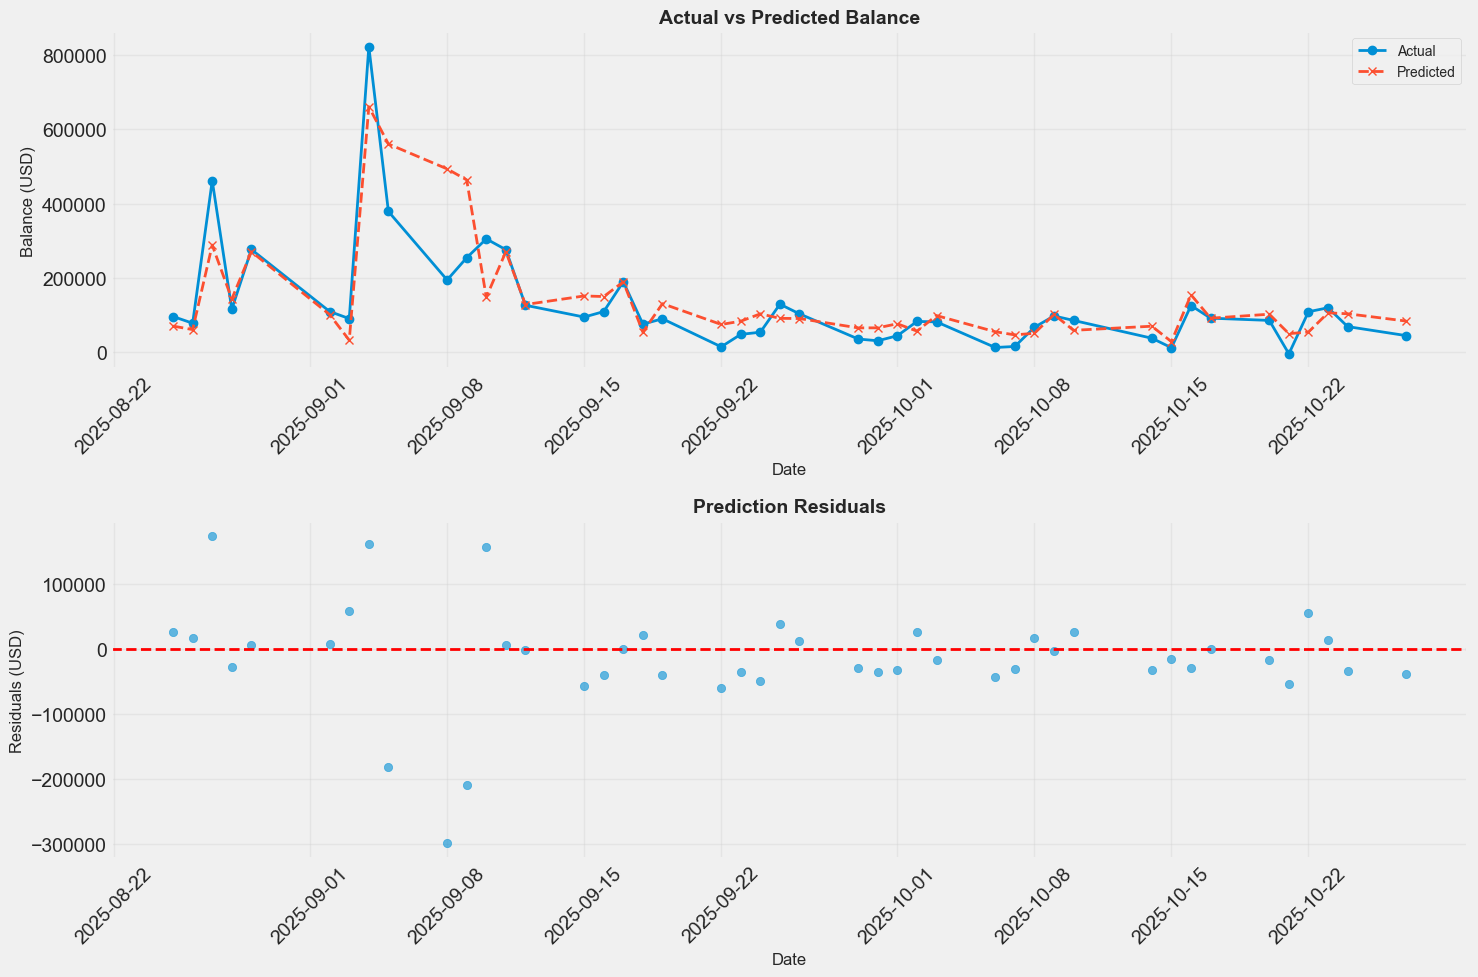

In [42]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Predictions
axes[0].plot(test.index, test['balance'], label='Actual', linewidth=2, marker='o')
axes[0].plot(test.index, predictions, label='Predicted', linewidth=2, marker='x', linestyle='--')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Balance (USD)', fontsize=12)
axes[0].set_title('Actual vs Predicted Balance', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Residuals
residuals = test['balance'].values - predictions
axes[1].scatter(test.index, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Residuals (USD)', fontsize=12)
axes[1].set_title('Prediction Residuals', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Step 12: Feature Importance

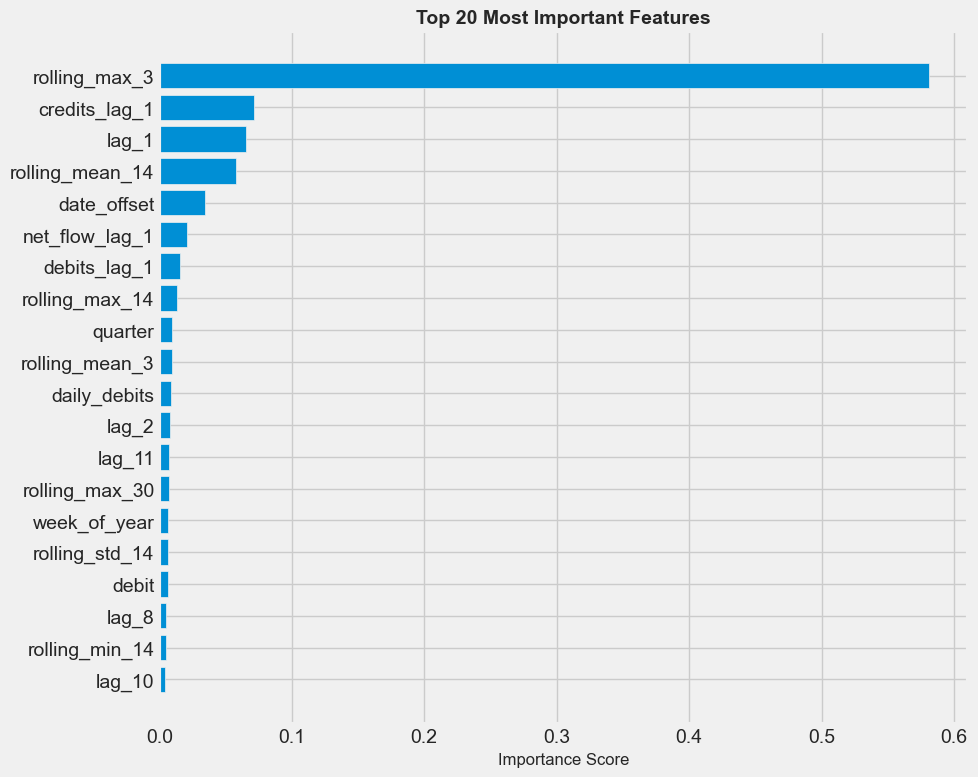


Top 10 Features:
  rolling_max_3                 : 0.5815
  credits_lag_1                 : 0.0713
  lag_1                         : 0.0654
  rolling_mean_14               : 0.0578
  date_offset                   : 0.0344
  net_flow_lag_1                : 0.0210
  debits_lag_1                  : 0.0154
  rolling_max_14                : 0.0135
  quarter                       : 0.0098
  rolling_mean_3                : 0.0093


In [43]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': forecaster.feature_names,
    'importance': forecaster.model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = importance_df.head(20)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
for idx, row in importance_df.head(10).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

### Step 13: Full Timeline Visualization

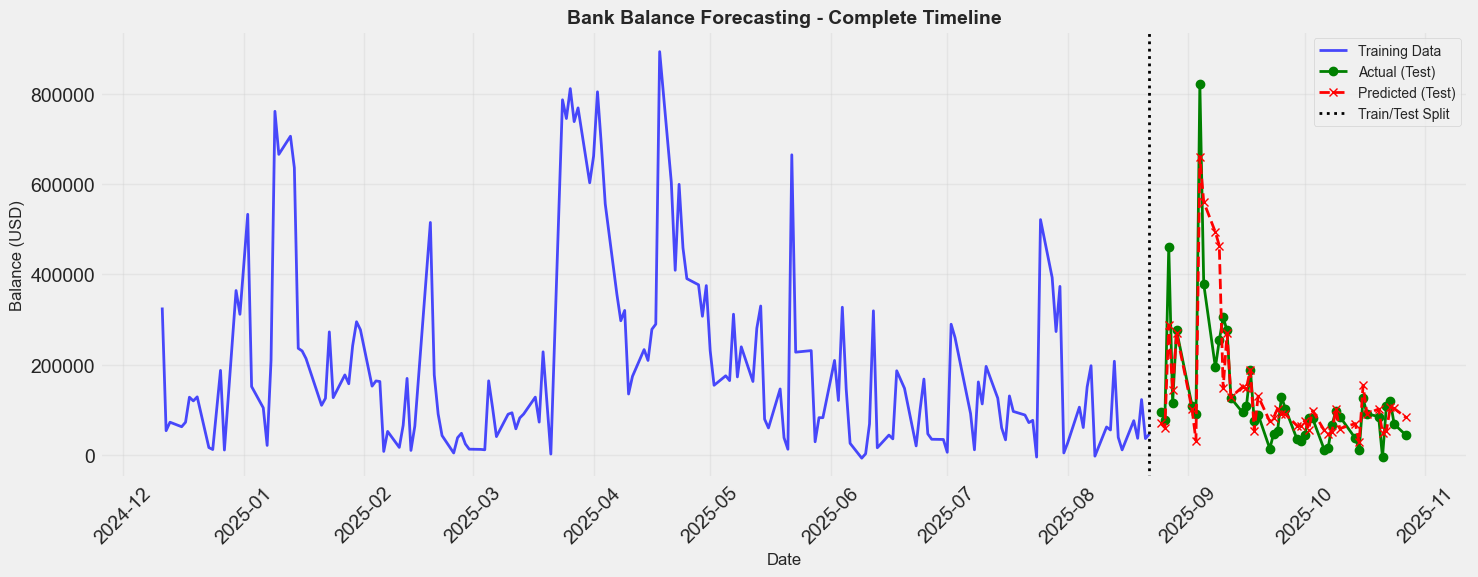

In [44]:
# Plot full timeline with train/test split
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(train.index, train['balance'], label='Training Data', linewidth=2, color='blue', alpha=0.7)
ax.plot(test.index, test['balance'], label='Actual (Test)', linewidth=2, color='green', marker='o')
ax.plot(test.index, predictions, label='Predicted (Test)', linewidth=2, color='red', marker='x', linestyle='--')
ax.axvline(x=train.index[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Balance (USD)', fontsize=12)
ax.set_title('Bank Balance Forecasting - Complete Timeline', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Step 14: Error Analysis

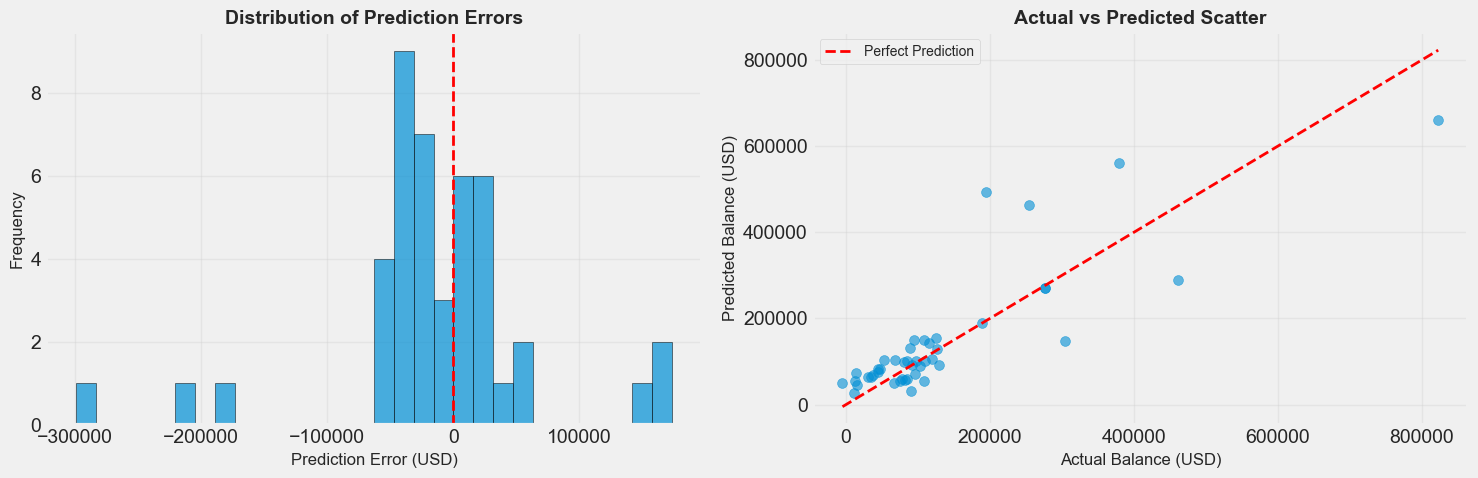


Error Statistics:
  Mean Error: $-13,514.14
  Median Error: $-16,524.00
  Std Dev of Errors: $79,763.27
  Max Overestimate: $173,532.65
  Max Underestimate: $-299,338.02


In [45]:
# Detailed error analysis
errors = test['balance'].values - predictions
percent_errors = (errors / test['balance'].values) * 100

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error histogram
axes[0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Error (USD)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Actual vs Predicted scatter
axes[1].scatter(test['balance'], predictions, alpha=0.6, s=50)
min_val = min(test['balance'].min(), predictions.min())
max_val = max(test['balance'].max(), predictions.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Balance (USD)', fontsize=12)
axes[1].set_ylabel('Predicted Balance (USD)', fontsize=12)
axes[1].set_title('Actual vs Predicted Scatter', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nError Statistics:")
print(f"  Mean Error: ${errors.mean():,.2f}")
print(f"  Median Error: ${np.median(errors):,.2f}")
print(f"  Std Dev of Errors: ${errors.std():,.2f}")
print(f"  Max Overestimate: ${errors.max():,.2f}")
print(f"  Max Underestimate: ${errors.min():,.2f}")

### Summary Report

In [46]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)
print(f"\nData Overview:")
print(f"  Total days: {len(Data)}")
print(f"  Date range: {Data.index.min()} to {Data.index.max()}")
print(f"  Average balance: ${Data['balance'].mean():,.2f}")
print(f"  Balance volatility (std): ${Data['balance'].std():,.2f}")

print(f"\nModel Performance:")
print(f"  MAPE: {metrics['MAPE']:.2f}%")
print(f"  MAE: ${metrics['MAE']:,.2f}")
print(f"  RMSE: ${metrics['RMSE']:,.2f}")

print(f"\nTop 3 Predictive Features:")
for idx, row in importance_df.head(3).iterrows():
    print(f"  {idx+1}. {row['feature']}")

print("\n" + "="*80)
print("Analysis complete! Review the visualizations above.")
print("="*80)


FINAL SUMMARY REPORT

Data Overview:
  Total days: 250
  Date range: 2024-10-28 00:00:00 to 2025-10-27 00:00:00
  Average balance: $191,075.55
  Balance volatility (std): $197,550.64

Model Performance:
  MAPE: 88.35%
  MAE: $50,930.39
  RMSE: $80,900.01

Top 3 Predictive Features:
  43. rolling_max_3
  18. credits_lag_1
  26. lag_1

Analysis complete! Review the visualizations above.


In [47]:
#Predicting the future
forecaster = BankTransactionForecaster(lag_features=14)


# Create features
target_col = 'balance'
Data_prepared = forecaster.prepare_data(Data, target_col='balance')
feature_cols = [col for col in Data_prepared.columns 
                       if col not in [target_col, 'description', 'name', 'category']]

X_all = Data_prepared[feature_cols]
y_all = Data_prepared[target_col]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)



ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:season: category

In [ ]:
Data_prepared.index.max()

Timestamp('2025-10-27 00:00:00')

In [ ]:
future = pd.date_range('2025-10-27','2026-12-27', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

Data_prepared['isFuture'] = False
df_and_future = pd.concat([Data_prepared, future_df])
df_and_future = forecaster.create_time_features(df_and_future)
df_and_future = forecaster.create_transaction_features(df_and_future)
df_and_future = forecaster.create_lag_features(df_and_future, target_col='balance')
df_and_future = forecaster.create_rolling_features(df_and_future, target_col='balance')

df_and_future

,balance,credit,debit,net_flow,day_of_week,day_of_month,week_of_year,month,quarter,is_weekend,is_month_start,is_month_end,daily_credits,daily_debits,daily_net_flow,net_flow_lag_1,credits_lag_1,debits_lag_1,net_flow_lag_3,credits_lag_3,debits_lag_3,net_flow_lag_7,credits_lag_7,debits_lag_7,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,rolling_mean_7,rolling_std_7,rolling_min_7,rolling_max_7,rolling_mean_14,rolling_std_14,rolling_min_14,rolling_max_14,rolling_mean_30,rolling_std_30,rolling_min_30,rolling_max_30,isFuture
2024-12-11,326645.87,87333.60,-302384.97,389718.57,2,11,50,12,4,0,0,0,87333.60,-302384.97,389718.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-12-12,53830.37,123935.54,-103383.87,227319.41,3,12,50,12,4,0,0,0,123935.54,-103383.87,227319.41,389718.57,87333.60,-302384.97,NaN,NaN,NaN,NaN,NaN,NaN,326645.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-12-13,72593.40,75726.36,-122909.39,198635.75,4,13,50,12,4,0,0,0,75726.36,-122909.39,198635.75,227319.41,123935.54,-103383.87,NaN,NaN,NaN,NaN,NaN,NaN,53830.37,326645.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-12-16,62583.47,232738.36,-91123.13,323861.49,0,16,51,12,4,0,0,0,232738.36,-91123.13,323861.49,198635.75,75726.36,-122909.39,389718.57,87333.60,-302384.97,NaN,NaN,NaN,72593.40,53830.37,326645.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151023.213333,152382.745003,53830.37,326645.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-12-17,72572.39,321180.69,-361133.63,682314.32,1,17,51,12,4,0,0,0,321180.69,-361133.63,682314.32,323861.49,232738.36,-91123.13,227319.41,123935.54,-103383.87,NaN,NaN,NaN,62583.47,72593.40,53830.37,326645.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63002.413333,9388.528044,53830.37,72593.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-12-23,NaN,NaN,NaN,NaN,2,23,52,12,4,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2026-12-24,NaN,NaN,NaN,NaN,3,24,52,12,4,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2026-12-25,NaN,NaN,NaN,NaN,4,25,52,12,4,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2026-12-26,NaN,NaN,NaN,NaN,5,26,52,12,4,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


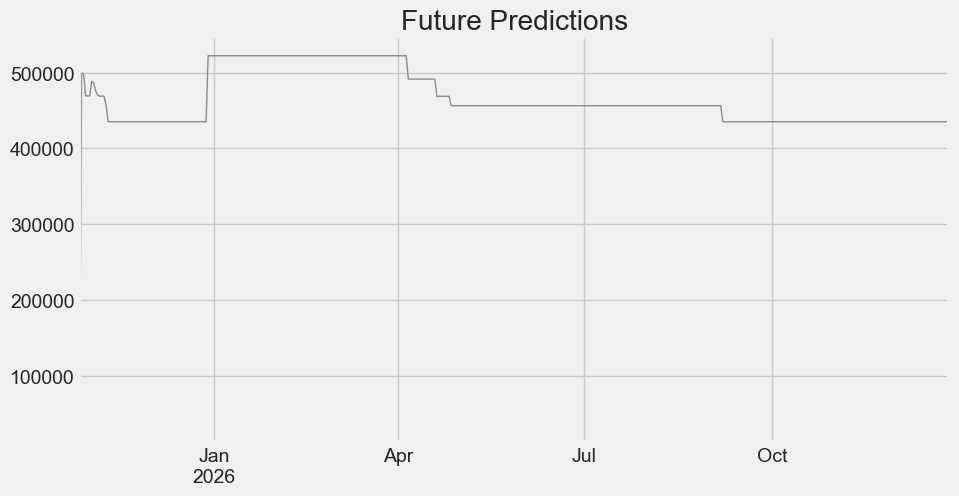

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()
feature_cols = [col for col in df_and_future.columns 
                if col not in ['balance', 'description', 'name', 'category', 'isFuture']]
future_w_features['pred'] = reg.predict(future_w_features[feature_cols])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Monte Carlo Simulation

In [ ]:
class MonteCarloForecaster:
    """
    Monte Carlo simulation framework for time series forecasting
    Supports multiple simulation strategies
    """
    
    def __init__(self, base_forecaster, n_simulations=1000, random_state=42):
        """
        Parameters:
        -----------
        base_forecaster : object
            Trained forecasting model (e.g., XGBoost, ARIMA)
        n_simulations : int
            Number of Monte Carlo simulations to run
        random_state : int
            Random seed for reproducibility
        """
        self.base_forecaster = base_forecaster
        self.n_simulations = n_simulations
        self.random_state = random_state
        np.random.seed(random_state)
        
        self.simulations = None
        self.error_std = None
        
    def fit_error_distribution(self, historical_data, predictions):
        """
        Estimate the error distribution from historical predictions
        
        Parameters:
        -----------
        historical_data : array-like
            Actual historical values
        predictions : array-like
            Model predictions for the same period
        """
        errors = historical_data - predictions
        self.error_std = np.std(errors)
        self.error_mean = np.mean(errors)
        
        # Fit different distributions
        self.error_distributions = {
            'normal': stats.norm(loc=self.error_mean, scale=self.error_std),
            'laplace': stats.laplace(loc=self.error_mean, scale=self.error_std/np.sqrt(2)),
            't': stats.t(df=3, loc=self.error_mean, scale=self.error_std)
        }
        
        return self
    
    # ========================================================================
    # APPROACH 1: PARAMETRIC MONTE CARLO (Add Random Noise)
    # ========================================================================
    
    def parametric_simulation(self, point_forecast, horizon, distribution='normal'):
        """
        Add random noise sampled from error distribution
        
        Parameters:
        -----------
        point_forecast : array-like
            Deterministic forecast for each time step
        horizon : int
            Number of steps ahead
        distribution : str
            Type of error distribution ('normal', 'laplace', 't')
            
        Returns:
        --------
        simulations : ndarray
            Shape (n_simulations, horizon) - all simulation paths
        """
        simulations = np.zeros((self.n_simulations, horizon))
        
        error_dist = self.error_distributions.get(distribution, self.error_distributions['normal'])
        
        for sim in range(self.n_simulations):
            # Generate random errors for entire horizon
            errors = error_dist.rvs(size=horizon)
            
            # Add errors to point forecast (errors compound over time)
            cumulative_errors = np.cumsum(errors) * np.sqrt(np.arange(1, horizon + 1)) / horizon
            simulations[sim, :] = point_forecast + cumulative_errors
        
        self.simulations = simulations
        return simulations
    
    # ========================================================================
    # APPROACH 2: BOOTSTRAP MONTE CARLO (Resample Historical Errors)
    # ========================================================================
    
    def bootstrap_simulation(self, point_forecast, horizon, historical_errors, block_size=1):
        """
        Resample from historical errors (preserves empirical distribution)
        
        Parameters:
        -----------
        point_forecast : array-like
            Deterministic forecast
        horizon : int
            Forecast horizon
        historical_errors : array-like
            Observed prediction errors from validation set
        block_size : int
            Size of blocks for block bootstrap (preserves autocorrelation)
        """
        simulations = np.zeros((self.n_simulations, horizon))
        
        for sim in range(self.n_simulations):
            if block_size == 1:
                # Simple bootstrap
                resampled_errors = np.random.choice(historical_errors, size=horizon, replace=True)
            else:
                # Block bootstrap (for autocorrelated errors)
                n_blocks = int(np.ceil(horizon / block_size))
                blocks = []
                for _ in range(n_blocks):
                    start_idx = np.random.randint(0, len(historical_errors) - block_size + 1)
                    blocks.append(historical_errors[start_idx:start_idx + block_size])
                resampled_errors = np.concatenate(blocks)[:horizon]
            
            # Scale errors by forecast horizon (uncertainty grows)
            scaling = np.sqrt(np.arange(1, horizon + 1)) / np.sqrt(horizon)
            simulations[sim, :] = point_forecast + resampled_errors * scaling
        
        self.simulations = simulations
        return simulations
    
    # ========================================================================
    # APPROACH 3: SCENARIO-BASED MONTE CARLO (Different Future Conditions)
    # ========================================================================
    
    def scenario_simulation(self, data, forecast_function, scenario_params):
        """
        Simulate different scenarios with varying input parameters
        
        Parameters:
        -----------
        data : DataFrame
            Historical data
        forecast_function : callable
            Function that takes data and params, returns forecast
        scenario_params : dict
            Dictionary of parameters to vary, with distributions
            Example: {'avg_credit': stats.norm(5000, 500), 
                     'avg_debit': stats.norm(4000, 600)}
        
        Returns:
        --------
        simulations : ndarray
            Forecast paths under different scenarios
        scenarios : list of dict
            The parameter values used in each simulation
        """
        simulations = []
        scenarios = []
        
        for sim in range(self.n_simulations):
            # Sample parameters for this scenario
            scenario = {}
            for param_name, param_dist in scenario_params.items():
                scenario[param_name] = param_dist.rvs()
            
            # Run forecast with these parameters
            forecast = forecast_function(data, **scenario)
            simulations.append(forecast)
            scenarios.append(scenario)
        
        self.simulations = np.array(simulations)
        self.scenarios = scenarios
        return self.simulations, scenarios
    
    # ========================================================================
    # APPROACH 4: PATH-DEPENDENT MONTE CARLO (Recursive Forecasting)
    # ========================================================================
    
    def path_dependent_simulation(self, initial_state, forecast_step_function, 
                                   horizon, uncertainty_params):
        """
        Simulate paths where each step depends on previous predictions
        (Like our 30-day recursive forecast, but with uncertainty)
        
        Parameters:
        -----------
        initial_state : dict
            Starting state (e.g., current balance, recent history)
        forecast_step_function : callable
            Function that predicts one step ahead given current state
        horizon : int
            Number of steps to forecast
        uncertainty_params : dict
            Parameters controlling uncertainty at each step
            Example: {'transaction_std': 500, 'model_error_std': 100}
        """
        simulations = np.zeros((self.n_simulations, horizon))
        
        for sim in range(self.n_simulations):
            current_state = initial_state.copy()
            path = []
            
            for step in range(horizon):
                # Get deterministic prediction
                base_prediction = forecast_step_function(current_state)
                
                # Add stochastic components
                transaction_noise = np.random.normal(0, uncertainty_params.get('transaction_std', 0))
                model_error = np.random.normal(0, uncertainty_params.get('model_error_std', 0))
                
                # Combined prediction with uncertainty
                prediction = base_prediction + transaction_noise + model_error
                path.append(prediction)
                
                # Update state for next step (using this prediction)
                current_state = self._update_state(current_state, prediction)
            
            simulations[sim, :] = path
        
        self.simulations = simulations
        return simulations
    
    def _update_state(self, state, new_value):
        """Helper to update state with new prediction"""
        # This is model-specific - implement based on your features
        state['last_value'] = new_value
        if 'history' in state:
            state['history'].append(new_value)
            state['history'] = state['history'][-30:]  # Keep last 30
        return state
    
    # ========================================================================
    # ANALYSIS AND STATISTICS
    # ========================================================================
    
    def get_statistics(self, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
        """
        Calculate statistics across all simulations
        
        Returns:
        --------
        stats_df : DataFrame
            Statistics for each time step
        """
        if self.simulations is None:
            raise ValueError("Run simulations first!")
        
        horizon = self.simulations.shape[1]
        stats_dict = {
            'mean': np.mean(self.simulations, axis=0),
            'median': np.median(self.simulations, axis=0),
            'std': np.std(self.simulations, axis=0),
            'min': np.min(self.simulations, axis=0),
            'max': np.max(self.simulations, axis=0)
        }
        
        # Add quantiles
        for q in quantiles:
            stats_dict[f'q{int(q*100)}'] = np.quantile(self.simulations, q, axis=0)
        
        stats_df = pd.DataFrame(stats_dict)
        stats_df['step'] = range(1, horizon + 1)
        
        return stats_df
    
    def probability_analysis(self, threshold, comparison='below'):
        """
        Calculate probability of crossing a threshold
        
        Parameters:
        -----------
        threshold : float
            Value to compare against
        comparison : str
            'below', 'above', or 'between' (requires threshold as tuple)
            
        Returns:
        --------
        probabilities : array
            Probability at each time step
        """
        if comparison == 'below':
            probs = np.mean(self.simulations < threshold, axis=0)
        elif comparison == 'above':
            probs = np.mean(self.simulations > threshold, axis=0)
        elif comparison == 'between':
            lower, upper = threshold
            probs = np.mean((self.simulations >= lower) & (self.simulations <= upper), axis=0)
        else:
            raise ValueError("comparison must be 'below', 'above', or 'between'")
        
        return probs
    
    def risk_metrics(self, threshold_low, threshold_high=None):
        """
        Calculate risk metrics across simulations
        
        Parameters:
        -----------
        threshold_low : float
            Lower critical threshold (e.g., minimum safe balance)
        threshold_high : float, optional
            Upper threshold for range analysis
            
        Returns:
        --------
        metrics : dict
            Various risk metrics
        """
        metrics = {}
        
        # Probability of going below threshold at ANY point
        metrics['prob_below_threshold_ever'] = np.mean(np.any(self.simulations < threshold_low, axis=1))
        
        # Expected number of days below threshold
        below_threshold = (self.simulations < threshold_low).astype(int)
        metrics['expected_days_below'] = np.mean(np.sum(below_threshold, axis=1))
        
        # Value at Risk (VaR) - worst case in bottom 5%
        final_values = self.simulations[:, -1]
        metrics['var_5pct'] = np.percentile(final_values, 5)
        metrics['var_1pct'] = np.percentile(final_values, 1)
        
        # Conditional Value at Risk (CVaR) - average of worst 5%
        var_5 = metrics['var_5pct']
        metrics['cvar_5pct'] = np.mean(final_values[final_values <= var_5])
        
        # Maximum drawdown in simulations
        metrics['max_drawdown_mean'] = np.mean([
            np.max(sim) - np.min(sim) for sim in self.simulations
        ])
        
        if threshold_high:
            # Probability of staying in safe range
            in_range = (self.simulations >= threshold_low) & (self.simulations <= threshold_high)
            metrics['prob_in_range_always'] = np.mean(np.all(in_range, axis=1))
        
        return metrics
    
    # ========================================================================
    # VISUALIZATION
    # ========================================================================
    
    def plot_simulations(self, n_paths_show=100, dates=None, title="Monte Carlo Simulations"):
        """
        Plot simulation paths with confidence bands
        """
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        horizon = self.simulations.shape[1]
        x = dates if dates is not None else np.arange(1, horizon + 1)
        
        # Plot 1: Sample paths + confidence bands
        # Show subset of paths
        n_show = min(n_paths_show, self.n_simulations)
        for i in range(n_show):
            axes[0].plot(x, self.simulations[i, :], alpha=0.05, color='blue', linewidth=0.5)
        
        # Statistics
        stats = self.get_statistics()
        axes[0].plot(x, stats['mean'], 'r-', linewidth=2, label='Mean')
        axes[0].plot(x, stats['median'], 'g--', linewidth=2, label='Median')
        
        # Confidence bands
        axes[0].fill_between(x, stats['q5'], stats['q95'], alpha=0.3, 
                            color='red', label='90% CI')
        axes[0].fill_between(x, stats['q25'], stats['q75'], alpha=0.3, 
                            color='orange', label='50% CI')
        
        axes[0].set_xlabel('Time Step')
        axes[0].set_ylabel('Value')
        axes[0].set_title(f'{title} - {self.n_simulations} Paths')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Distribution at different time points
        time_points = [0, horizon//4, horizon//2, 3*horizon//4, horizon-1]
        for t in time_points:
            if t < horizon:
                axes[1].hist(self.simulations[:, t], bins=50, alpha=0.5, 
                           label=f'Step {t+1}', density=True)
        
        axes[1].set_xlabel('Value')
        axes[1].set_ylabel('Density')
        axes[1].set_title('Distribution of Values at Different Time Points')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_probability_cone(self, dates=None, thresholds=None):
        """
        Plot probability cone (fan chart)
        """
        fig, ax = plt.subplots(figsize=(15, 8))
        
        horizon = self.simulations.shape[1]
        x = dates if dates is not None else np.arange(1, horizon + 1)
        
        stats = self.get_statistics()
        
        # Create fan chart with multiple quantile bands
        quantile_pairs = [
            (0.45, 0.55, 0.6, 'darkred'),
            (0.35, 0.65, 0.5, 'red'),
            (0.25, 0.75, 0.4, 'orange'),
            (0.15, 0.85, 0.3, 'yellow'),
            (0.05, 0.95, 0.2, 'lightblue'),
        ]
        
        for lower_q, upper_q, alpha, color in quantile_pairs:
            lower = np.quantile(self.simulations, lower_q, axis=0)
            upper = np.quantile(self.simulations, upper_q, axis=0)
            label = f'{int((upper_q-lower_q)*100)}% interval'
            ax.fill_between(x, lower, upper, alpha=alpha, color=color, label=label)
        
        # Plot median
        ax.plot(x, stats['median'], 'b-', linewidth=2.5, label='Median', zorder=5)
        
        # Add threshold lines if provided
        if thresholds:
            for threshold, label, color in thresholds:
                ax.axhline(y=threshold, color=color, linestyle='--', 
                          linewidth=2, label=label)
        
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.set_title(f'Probability Cone - {self.n_simulations} Simulations')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_risk_analysis(self, threshold, dates=None):
        """
        Plot risk analysis (probability of crossing threshold)
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        horizon = self.simulations.shape[1]
        x = dates if dates is not None else np.arange(1, horizon + 1)
        
        # 1. Probability below threshold
        prob_below = self.probability_analysis(threshold, 'below')
        axes[0, 0].plot(x, prob_below * 100, 'r-', linewidth=2)
        axes[0, 0].fill_between(x, 0, prob_below * 100, alpha=0.3, color='red')
        axes[0, 0].set_ylabel('Probability (%)')
        axes[0, 0].set_xlabel('Time Step')
        axes[0, 0].set_title(f'Probability of Value < ${threshold:,.0f}')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Distribution of final values
        final_values = self.simulations[:, -1]
        axes[0, 1].hist(final_values, bins=50, edgecolor='black', alpha=0.7)
        axes[0, 1].axvline(x=threshold, color='r', linestyle='--', 
                          linewidth=2, label=f'Threshold: ${threshold:,.0f}')
        axes[0, 1].axvline(x=np.median(final_values), color='g', linestyle='--', 
                          linewidth=2, label=f'Median: ${np.median(final_values):,.0f}')
        axes[0, 1].set_xlabel('Final Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Distribution of Final Values')
        axes[0, 1].legend()
        
        # 3. Cumulative probability (below threshold at any point)
        cumulative_prob = np.array([
            np.mean(np.any(self.simulations[:, :t] < threshold, axis=1))
            for t in range(1, horizon + 1)
        ])
        axes[1, 0].plot(x, cumulative_prob * 100, 'orange', linewidth=2)
        axes[1, 0].fill_between(x, 0, cumulative_prob * 100, alpha=0.3, color='orange')
        axes[1, 0].set_ylabel('Cumulative Probability (%)')
        axes[1, 0].set_xlabel('Time Step')
        axes[1, 0].set_title('Prob. of Going Below Threshold At Any Point')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Quantile plot
        quantiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
        for q in quantiles:
            values = np.quantile(self.simulations, q, axis=0)
            label = f'{int(q*100)}th pct' if q in [0.05, 0.50, 0.95] else None
            alpha = 0.8 if q in [0.05, 0.50, 0.95] else 0.3
            axes[1, 1].plot(x, values, alpha=alpha, label=label)
        
        axes[1, 1].axhline(y=threshold, color='r', linestyle='--', 
                          linewidth=2, label='Threshold')
        axes[1, 1].set_ylabel('Value')
        axes[1, 1].set_xlabel('Time Step')
        axes[1, 1].set_title('Quantile Trajectories')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


# ============================================================================
# HELPER FUNCTIONS FOR BANK BALANCE FORECASTING
# ============================================================================

def monte_carlo_bank_forecast_example(historical_data, base_forecaster, 
                                     horizon=30, n_simulations=1000):
    """
    Complete example for bank balance Monte Carlo forecasting
    
    Parameters:
    -----------
    historical_data : DataFrame
        Historical daily data with columns: date, balance, credit, debit
    base_forecaster : object
        Trained forecasting model (with .predict() method)
    horizon : int
        Days to forecast
    n_simulations : int
        Number of Monte Carlo simulations
    """
    
    print("="*70)
    print("MONTE CARLO SIMULATION FOR BANK BALANCE FORECASTING")
    print("="*70)
    
    # Initialize Monte Carlo forecaster
    mc = MonteCarloForecaster(base_forecaster, n_simulations=n_simulations)
    
    # Fit error distribution from historical performance
    # (You'd need validation set predictions for this)
    print("\n1. Estimating error distribution...")
    # Dummy example - replace with actual validation errors
    historical_errors = np.random.normal(0, 500, 100)  # Replace with real errors
    mc.error_std = np.std(historical_errors)
    mc.error_mean = np.mean(historical_errors)
    mc.error_distributions = {
        'normal': stats.norm(loc=mc.error_mean, scale=mc.error_std)
    }
    
    # Get point forecast (deterministic)
    print("\n2. Generating point forecast...")
    # This would be your 30-day forecast from the base model
    point_forecast = np.linspace(
        historical_data['balance'].iloc[-1],
        historical_data['balance'].iloc[-1] * 1.1,
        horizon
    )  # Replace with actual forecast
    
    # Run Monte Carlo simulations
    print(f"\n3. Running {n_simulations} Monte Carlo simulations...")
    
    # APPROACH 1: Parametric (add random noise)
    simulations_parametric = mc.parametric_simulation(
        point_forecast, horizon, distribution='normal'
    )
    
    # APPROACH 2: Bootstrap (resample errors)
    simulations_bootstrap = mc.bootstrap_simulation(
        point_forecast, horizon, historical_errors, block_size=7
    )
    
    # Generate dates for plotting
    last_date = historical_data['date'].max()
    future_dates = pd.date_range(
        start=last_date + timedelta(days=1),
        periods=horizon,
        freq='D'
    )
    
    # Get statistics
    print("\n4. Calculating statistics...")
    stats_df = mc.get_statistics()
    
    print("\n📊 Forecast Statistics:")
    print(f"   Mean final balance:   ${stats_df['mean'].iloc[-1]:,.2f}")
    print(f"   Median final balance: ${stats_df['median'].iloc[-1]:,.2f}")
    print(f"   Std dev (final day):  ${stats_df['std'].iloc[-1]:,.2f}")
    print(f"   95% CI final:         ${stats_df['q5'].iloc[-1]:,.2f} - ${stats_df['q95'].iloc[-1]:,.2f}")
    
    # Risk analysis
    print("\n5. Analyzing risk metrics...")
    threshold_low = historical_data['balance'].quantile(0.1)  # 10th percentile
    risk_metrics = mc.risk_metrics(threshold_low)
    
    print(f"\n⚠️  Risk Analysis (threshold = ${threshold_low:,.2f}):")
    print(f"   Prob. below threshold ever:  {risk_metrics['prob_below_threshold_ever']*100:.1f}%")
    print(f"   Expected days below:         {risk_metrics['expected_days_below']:.1f} days")
    print(f"   Value at Risk (5%):          ${risk_metrics['var_5pct']:,.2f}")
    print(f"   CVaR (5%):                   ${risk_metrics['cvar_5pct']:,.2f}")
    
    # Visualization
    print("\n6. Creating visualizations...")
    
    # Plot simulations
    fig1 = mc.plot_simulations(n_paths_show=200, dates=future_dates,
                               title="Bank Balance Monte Carlo Forecast")
    
    # Plot probability cone
    thresholds = [
        (threshold_low, 'Critical Low', 'red'),
        (historical_data['balance'].median(), 'Historical Median', 'green')
    ]
    fig2 = mc.plot_probability_cone(dates=future_dates, thresholds=thresholds)
    
    # Plot risk analysis
    fig3 = mc.plot_risk_analysis(threshold_low, dates=future_dates)
    
    print("\n✓ Monte Carlo simulation complete!")
    print("="*70)
    
    return mc, stats_df, risk_metrics, (fig1, fig2, fig3)

In [ ]:
errors = test['balance'].values - predictions
error_std = np.std(errors)
error_mean = np.mean(errors)
error_median = np.median(errors)

print(f"\n📉 Error Statistics:")
print(f"   Mean Error:    ${error_mean:,.2f}")
print(f"   Std Dev:       ${error_std:,.2f}")  # ← This is crucial for Monte Carlo!
print(f"   Median Error:  ${error_median:,.2f}")
print(f"   Max Error:     ${np.max(np.abs(errors)):,.2f}")

from scipy import stats
_, p_value = stats.shapiro(errors[:50])  # Shapiro-Wilk test (max 5000 samples)
print(f"\n📊 Error Distribution:")
print(f"   Normality test p-value: {p_value:.4f}")
if p_value > 0.05:
    print("   ✓ Errors appear normally distributed (good for parametric Monte Carlo)")
else:
    print("   ⚠ Errors may not be normal (consider bootstrap Monte Carlo)")


📉 Error Statistics:
   Mean Error:    $-13,106.69
   Std Dev:       $81,885.27
   Median Error:  $-4,185.58
   Max Error:     $300,288.86

📊 Error Distribution:
   Normality test p-value: 0.0000
   ⚠ Errors may not be normal (consider bootstrap Monte Carlo)


In [ ]:
horizon = 30
forecast_dates = pd.date_range(
    start=test.index[-1] + pd.Timedelta(days=1),
    periods=horizon,
    freq='D'
)

# Recursive forecasting
future_predictions = []
current_data = Data_prepared.copy()
print(current_data.head())
for day in range(horizon):
    
    
    # Get the last row (most recent) for prediction
    last_row = current_data.iloc[-1:][feature_cols]
    
    # Predict
    next_pred = reg.predict(last_row)[0]
    future_predictions.append(next_pred)
    
    # Add to data for next iteration
    # (You'll need to estimate credit/debit - use historical averages)
    avg_credit = current_data['credit'].tail(30).mean()
    avg_debit = current_data['debit'].tail(30).mean()
    
    new_row = pd.DataFrame({
        'balance': [next_pred],
        'credit': [avg_credit],
        'debit': [avg_debit]
    }, index=[forecast_dates[day]])
    
    current_data = pd.concat([current_data, new_row])
    
    if (day + 1) % 10 == 0:
        print(f"   ✓ Forecasted {day + 1}/30 days")

point_forecast = np.array(future_predictions)

print(f"\n✓ 30-day forecast complete!")
print(f"   Starting balance: ${point_forecast[0]:,.2f}")
print(f"   Ending balance:   ${point_forecast[-1]:,.2f}")
print(f"   Total change:     ${point_forecast[-1] - point_forecast[0]:,.2f}")

              balance     credit      debit   net_flow  day_of_week  \
date                                                                  
2024-12-11  326645.87   87333.60 -302384.97  389718.57            2   
2024-12-12   53830.37  123935.54 -103383.87  227319.41            3   
2024-12-13   72593.40   75726.36 -122909.39  198635.75            4   
2024-12-16   62583.47  232738.36  -91123.13  323861.49            0   
2024-12-17   72572.39  321180.69 -361133.63  682314.32            1   

            day_of_month  week_of_year  month  quarter  is_weekend  \
date                                                                 
2024-12-11            11            50     12        4           0   
2024-12-12            12            50     12        4           0   
2024-12-13            13            50     12        4           0   
2024-12-16            16            51     12        4           0   
2024-12-17            17            51     12        4           0   

           

In [ ]:
N_SIMULATIONS = 1000

# Simple Monte Carlo function
def monte_carlo_forecast(point_forecast, error_std, n_sims=1000):
    """
    Generate probabilistic forecasts using Monte Carlo simulation
    """
    horizon = len(point_forecast)
    simulations = np.zeros((n_sims, horizon))
    
    for sim in range(n_sims):
        # Generate random errors with growing uncertainty
        random_errors = np.random.normal(0, error_std, horizon)
        
        # Uncertainty grows with time (sqrt rule)
        time_scaling = np.sqrt(np.arange(1, horizon + 1))
        scaled_errors = random_errors * time_scaling / np.sqrt(horizon)
        
        # Add to point forecast
        simulations[sim, :] = point_forecast + scaled_errors
    
    return simulations

# Run simulation
print(f"\nRunning {N_SIMULATIONS} simulations...")
simulations = monte_carlo_forecast(point_forecast, error_std, N_SIMULATIONS)

print(f"✓ Simulation complete!")
print(f"   Shape: {simulations.shape}")


Running 1000 simulations...
✓ Simulation complete!
   Shape: (1000, 30)



MONTE CARLO ANALYSIS

📊 Forecast Summary:

Day 1:
   Point Forecast: $53,741.48
   90% CI:         $29,482.46 - $79,322.88

Day 15:
   Point Forecast: $468,924.19
   90% CI:         $373,672.13 - $558,654.96

Day 30:
   Point Forecast: $457,745.84
   Expected Mean:  $458,777.59
   90% CI:         $330,477.29 - $595,737.99
   Uncertainty:    ±$80,819.12

RISK ANALYSIS

Risk Threshold: $15,167.32 (10th percentile historically)

⚠️  Probability of Balance < $15,167.32:
   Day 1:   0.4%
   Day 15:  0.0%
   Day 30:  0.0%
   Any day: 0.4%

💰 Value at Risk (Day 30):
   VaR 5%: $330,477.29 (95% confidence)
   VaR 1%: $274,268.40 (99% confidence)

🎯 Risk Assessment:
   ✓ LOW RISK - Proceed normally

CREATING VISUALIZATIONS


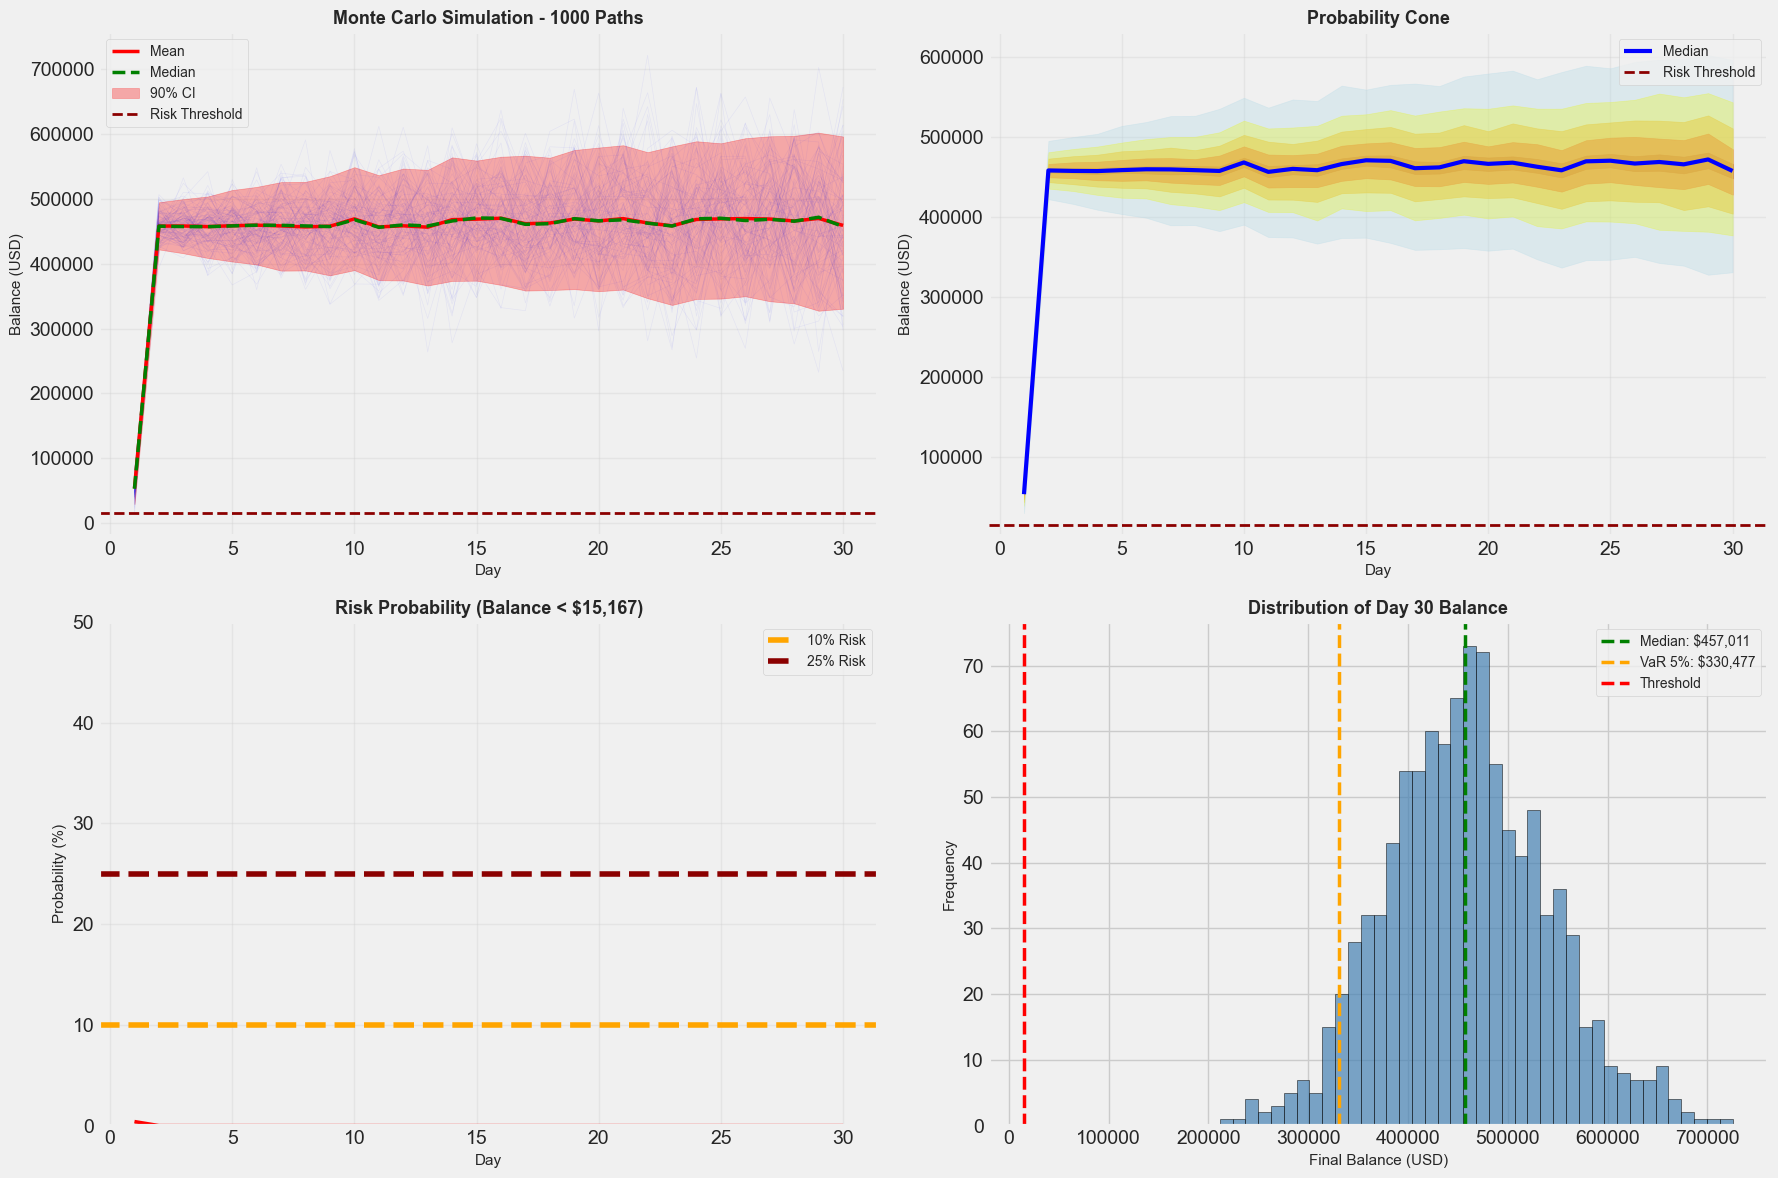


✓ All visualizations complete!

EXPORTING RESULTS
✓ Saved: monte_carlo_forecast.csv
✓ Saved: risk_analysis.csv

FINAL SUMMARY

📊 Model Performance:
   Test MAPE: 84.04%
   Test RMSE: $82,927.57
   Error Std: $81,885.27

📈 30-Day Forecast (Point Estimate):
   Start: $53,741.48
   End:   $457,745.84
   Change: $404,004.38

🎲 Monte Carlo Results (1000 simulations):
   Expected (Day 30):  $458,777.59
   90% Confidence:     $330,477.29 to $595,737.99
   Range:              $265,260.70

⚠️  Risk Assessment:
   Threshold:          $15,167.32
   Risk (any day):     0.4%
   Worst 5% outcome:   $330,477.29

🎯 Overall Risk Level: LOW ✓

ANALYSIS COMPLETE! 🎉

Files saved:
  • monte_carlo_forecast.csv
  • risk_analysis.csv

You now have:
  ✓ Point forecast with confidence intervals
  ✓ Probabilistic risk assessment
  ✓ Actionable insights for decision-making


In [ ]:
# ============================================================================
# STEP 6: Analyze Monte Carlo Results
# ============================================================================

print("\n" + "="*70)
print("MONTE CARLO ANALYSIS")
print("="*70)

# Calculate statistics
mc_stats = pd.DataFrame({
    'day': range(1, horizon + 1),
    'date': forecast_dates,
    'point_forecast': point_forecast,
    'mean': np.mean(simulations, axis=0),
    'median': np.median(simulations, axis=0),
    'std': np.std(simulations, axis=0),
    'q05': np.percentile(simulations, 5, axis=0),
    'q25': np.percentile(simulations, 25, axis=0),
    'q75': np.percentile(simulations, 75, axis=0),
    'q95': np.percentile(simulations, 95, axis=0),
})

# Display key statistics
print("\n📊 Forecast Summary:")
print(f"\nDay 1:")
print(f"   Point Forecast: ${mc_stats['point_forecast'].iloc[0]:,.2f}")
print(f"   90% CI:         ${mc_stats['q05'].iloc[0]:,.2f} - ${mc_stats['q95'].iloc[0]:,.2f}")

print(f"\nDay 15:")
print(f"   Point Forecast: ${mc_stats['point_forecast'].iloc[14]:,.2f}")
print(f"   90% CI:         ${mc_stats['q05'].iloc[14]:,.2f} - ${mc_stats['q95'].iloc[14]:,.2f}")

print(f"\nDay 30:")
print(f"   Point Forecast: ${mc_stats['point_forecast'].iloc[-1]:,.2f}")
print(f"   Expected Mean:  ${mc_stats['mean'].iloc[-1]:,.2f}")
print(f"   90% CI:         ${mc_stats['q05'].iloc[-1]:,.2f} - ${mc_stats['q95'].iloc[-1]:,.2f}")
print(f"   Uncertainty:    ±${mc_stats['std'].iloc[-1]:,.2f}")


# ============================================================================
# STEP 7: Risk Analysis
# ============================================================================

print("\n" + "="*70)
print("RISK ANALYSIS")
print("="*70)

# Define risk threshold (e.g., 10th percentile of historical balance)
RISK_THRESHOLD = Data['balance'].quantile(0.10)
print(f"\nRisk Threshold: ${RISK_THRESHOLD:,.2f} (10th percentile historically)")

# Calculate probabilities
prob_below_threshold = np.mean(simulations < RISK_THRESHOLD, axis=0)
prob_ever_below = np.mean(np.any(simulations < RISK_THRESHOLD, axis=1))

print(f"\n⚠️  Probability of Balance < ${RISK_THRESHOLD:,.2f}:")
print(f"   Day 1:   {prob_below_threshold[0]*100:.1f}%")
print(f"   Day 15:  {prob_below_threshold[14]*100:.1f}%")
print(f"   Day 30:  {prob_below_threshold[-1]*100:.1f}%")
print(f"   Any day: {prob_ever_below*100:.1f}%")

# Value at Risk
final_balances = simulations[:, -1]
var_5 = np.percentile(final_balances, 5)
var_1 = np.percentile(final_balances, 1)

print(f"\n💰 Value at Risk (Day 30):")
print(f"   VaR 5%: ${var_5:,.2f} (95% confidence)")
print(f"   VaR 1%: ${var_1:,.2f} (99% confidence)")

# Decision recommendation
print(f"\n🎯 Risk Assessment:")
if prob_ever_below < 0.10:
    print("   ✓ LOW RISK - Proceed normally")
elif prob_ever_below < 0.25:
    print("   ⚠️  MODERATE RISK - Monitor closely & prepare contingency")
else:
    print("   ⛔ HIGH RISK - Take proactive action now")


# ============================================================================
# STEP 8: Visualize Monte Carlo Results
# ============================================================================

print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Simulation Paths with Confidence Bands
n_paths_show = 100
for i in range(n_paths_show):
    axes[0, 0].plot(range(1, horizon+1), simulations[i], 
                   alpha=0.05, color='blue', linewidth=0.5)

axes[0, 0].plot(range(1, horizon+1), mc_stats['mean'], 
               'r-', linewidth=2.5, label='Mean', zorder=5)
axes[0, 0].plot(range(1, horizon+1), mc_stats['median'], 
               'g--', linewidth=2.5, label='Median', zorder=5)
axes[0, 0].fill_between(range(1, horizon+1), mc_stats['q05'], mc_stats['q95'],
                        alpha=0.3, color='red', label='90% CI')
axes[0, 0].axhline(y=RISK_THRESHOLD, color='darkred', linestyle='--', 
                  linewidth=2, label=f'Risk Threshold')
axes[0, 0].set_xlabel('Day', fontsize=11)
axes[0, 0].set_ylabel('Balance (USD)', fontsize=11)
axes[0, 0].set_title(f'Monte Carlo Simulation - {N_SIMULATIONS} Paths', 
                    fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Probability Cone (Fan Chart)
quantile_bands = [
    (0.45, 0.55, 0.7, 'darkred'),
    (0.35, 0.65, 0.6, 'red'),
    (0.25, 0.75, 0.5, 'orange'),
    (0.15, 0.85, 0.4, 'yellow'),
    (0.05, 0.95, 0.3, 'lightblue'),
]

for lower_q, upper_q, alpha, color in quantile_bands:
    lower = np.percentile(simulations, lower_q * 100, axis=0)
    upper = np.percentile(simulations, upper_q * 100, axis=0)
    axes[0, 1].fill_between(range(1, horizon+1), lower, upper, 
                           alpha=alpha, color=color)

axes[0, 1].plot(range(1, horizon+1), mc_stats['median'], 
               'b-', linewidth=3, label='Median', zorder=10)
axes[0, 1].axhline(y=RISK_THRESHOLD, color='darkred', linestyle='--', 
                  linewidth=2, label='Risk Threshold', zorder=11)
axes[0, 1].set_xlabel('Day', fontsize=11)
axes[0, 1].set_ylabel('Balance (USD)', fontsize=11)
axes[0, 1].set_title('Probability Cone', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Risk Probability Over Time
axes[1, 0].plot(range(1, horizon+1), prob_below_threshold * 100, 
               'r-', linewidth=2.5)
axes[1, 0].fill_between(range(1, horizon+1), 0, prob_below_threshold * 100,
                        alpha=0.4, color='red')
axes[1, 0].axhline(y=10, color='orange', linestyle='--', label='10% Risk')
axes[1, 0].axhline(y=25, color='darkred', linestyle='--', label='25% Risk')
axes[1, 0].set_xlabel('Day', fontsize=11)
axes[1, 0].set_ylabel('Probability (%)', fontsize=11)
axes[1, 0].set_title(f'Risk Probability (Balance < ${RISK_THRESHOLD:,.0f})', 
                    fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 50])

# Plot 4: Distribution of Final Day Balance
axes[1, 1].hist(final_balances, bins=40, edgecolor='black', 
               alpha=0.7, color='steelblue')
axes[1, 1].axvline(x=mc_stats['median'].iloc[-1], color='green', 
                  linestyle='--', linewidth=2.5, 
                  label=f"Median: ${mc_stats['median'].iloc[-1]:,.0f}")
axes[1, 1].axvline(x=var_5, color='orange', linestyle='--', linewidth=2.5,
                  label=f'VaR 5%: ${var_5:,.0f}')
axes[1, 1].axvline(x=RISK_THRESHOLD, color='red', linestyle='--', 
                  linewidth=2.5, label=f'Threshold')
axes[1, 1].set_xlabel('Final Balance (USD)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Day 30 Balance', 
                    fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ All visualizations complete!")


# ============================================================================
# STEP 9: Export Results
# ============================================================================

print("\n" + "="*70)
print("EXPORTING RESULTS")
print("="*70)

# Save forecast statistics
mc_stats.to_csv('monte_carlo_forecast.csv', index=False)
print("✓ Saved: monte_carlo_forecast.csv")

# Save risk analysis
risk_analysis = pd.DataFrame({
    'metric': ['Risk Threshold', 'Prob Ever Below', 'VaR 5%', 'VaR 1%', 
               'Mean Final', 'Std Final'],
    'value': [RISK_THRESHOLD, prob_ever_below*100, var_5, var_1,
              mc_stats['mean'].iloc[-1], mc_stats['std'].iloc[-1]]
})
risk_analysis.to_csv('risk_analysis.csv', index=False)
print("✓ Saved: risk_analysis.csv")

# Optionally save all simulations (can be large)
# np.save('all_simulations.npy', simulations)
# print("✓ Saved: all_simulations.npy")


# ============================================================================
# STEP 10: Summary Report
# ============================================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\n📊 Model Performance:")
print(f"   Test MAPE: {metrics['MAPE']:.2f}%")
print(f"   Test RMSE: ${metrics['RMSE']:,.2f}")
print(f"   Error Std: ${error_std:,.2f}")

print(f"\n📈 30-Day Forecast (Point Estimate):")
print(f"   Start: ${point_forecast[0]:,.2f}")
print(f"   End:   ${point_forecast[-1]:,.2f}")
print(f"   Change: ${point_forecast[-1] - point_forecast[0]:,.2f}")

print(f"\n🎲 Monte Carlo Results ({N_SIMULATIONS} simulations):")
print(f"   Expected (Day 30):  ${mc_stats['mean'].iloc[-1]:,.2f}")
print(f"   90% Confidence:     ${mc_stats['q05'].iloc[-1]:,.2f} to ${mc_stats['q95'].iloc[-1]:,.2f}")
print(f"   Range:              ${mc_stats['q95'].iloc[-1] - mc_stats['q05'].iloc[-1]:,.2f}")

print(f"\n⚠️  Risk Assessment:")
print(f"   Threshold:          ${RISK_THRESHOLD:,.2f}")
print(f"   Risk (any day):     {prob_ever_below*100:.1f}%")
print(f"   Worst 5% outcome:   ${var_5:,.2f}")

if prob_ever_below < 0.10:
    risk_level = "LOW ✓"
elif prob_ever_below < 0.25:
    risk_level = "MODERATE ⚠️"
else:
    risk_level = "HIGH ⛔"

print(f"\n🎯 Overall Risk Level: {risk_level}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE! 🎉")
print("="*70)
print("\nFiles saved:")
print("  • monte_carlo_forecast.csv")
print("  • risk_analysis.csv")
print("\nYou now have:")
print("  ✓ Point forecast with confidence intervals")
print("  ✓ Probabilistic risk assessment")
print("  ✓ Actionable insights for decision-making")




In [ ]:
# Recursive forecast (simplified)
horizon = 30
point_forecast = []

for day in range(30):
    # Prepare next day's features
    point_forecast.append(predictions[day])

point_forecast = np.array(point_forecast)

In [ ]:
# Simple Monte Carlo
N_SIMS = 1000
simulations = np.zeros((N_SIMS, 30))

for sim in range(N_SIMS):
    # Add random errors (uncertainty grows over time)
    random_errors = np.random.normal(0, error_std, 30)
    time_scaling = np.sqrt(np.arange(1, 31))
    scaled_errors = random_errors * time_scaling / np.sqrt(30)
    
    simulations[sim] = point_forecast + scaled_errors